In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

In [55]:
from utils.notebook_config import *
# Download latest version
file_path = "dataset/synthetic_coffee_health_10000.csv"

# Load the latest version
data = pd.read_csv(file_path)

data.head()

data.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [56]:
data = data[["Age","Caffeine_mg","Sleep_Hours","Sleep_Quality","BMI","Heart_Rate","Stress_Level","Health_Issues"]]

data.head()

,Age,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Health_Issues
0,40,328.1,7.5,Good,24.9,78,Low,NaN
1,33,94.1,6.2,Good,20.0,67,Low,NaN
2,42,503.7,5.9,Fair,22.7,59,Medium,Mild
3,53,249.2,7.3,Good,24.7,71,Low,Mild
4,32,298.0,5.3,Fair,24.1,76,Medium,Mild


In [57]:
#start with the visualization
#smoking and alcohol are boolean
#Gender Country and Sleep quality must be converted to numerals
"""Country could be hard to convert maybe we just sort them by GDP and give them descending numbers based on that or we use an index measuring health care. Coffee intake and estimated caffeine is redundent """
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            10000 non-null  int64  
 1   Caffeine_mg    10000 non-null  float64
 2   Sleep_Hours    10000 non-null  float64
 3   Sleep_Quality  10000 non-null  object 
 4   BMI            10000 non-null  float64
 5   Heart_Rate     10000 non-null  int64  
 6   Stress_Level   10000 non-null  object 
 7   Health_Issues  4059 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


,Age,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,34.949100,238.411010,6.636220,23.986860,70.617800
std,11.160939,137.748815,1.222055,3.906411,9.822951
min,18.000000,0.000000,3.000000,15.000000,50.000000
25%,26.000000,138.750000,5.800000,21.300000,64.000000
50%,34.000000,235.400000,6.600000,24.000000,71.000000
75%,43.000000,332.025000,7.500000,26.600000,77.000000
max,80.000000,780.300000,10.000000,38.200000,109.000000


In [58]:
# from IPython.display import display

# display(data['Country'].value_counts())
# display(data['Gender'].value_counts())
# display(data['Sleep_Quality'].value_counts())
# display(data['Health_Issues'].value_counts())
# display(data['Occupation'].value_counts())

In [59]:
#data[('Country_encoded')], country_categories= pd.factorize(data['Country'])
#data['Gender_encoded'], gender_categories = pd.factorize(data['Gender'])
data['Sleep_encoded'], sleep_categories = pd.factorize(data['Sleep_Quality'])
data['Health_encoded'], health_categories = pd.factorize(data['Health_Issues'])
#data['Occupation_encoded'], occupation_categories = pd.factorize(data['Occupation'])

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_44335/2198168833.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


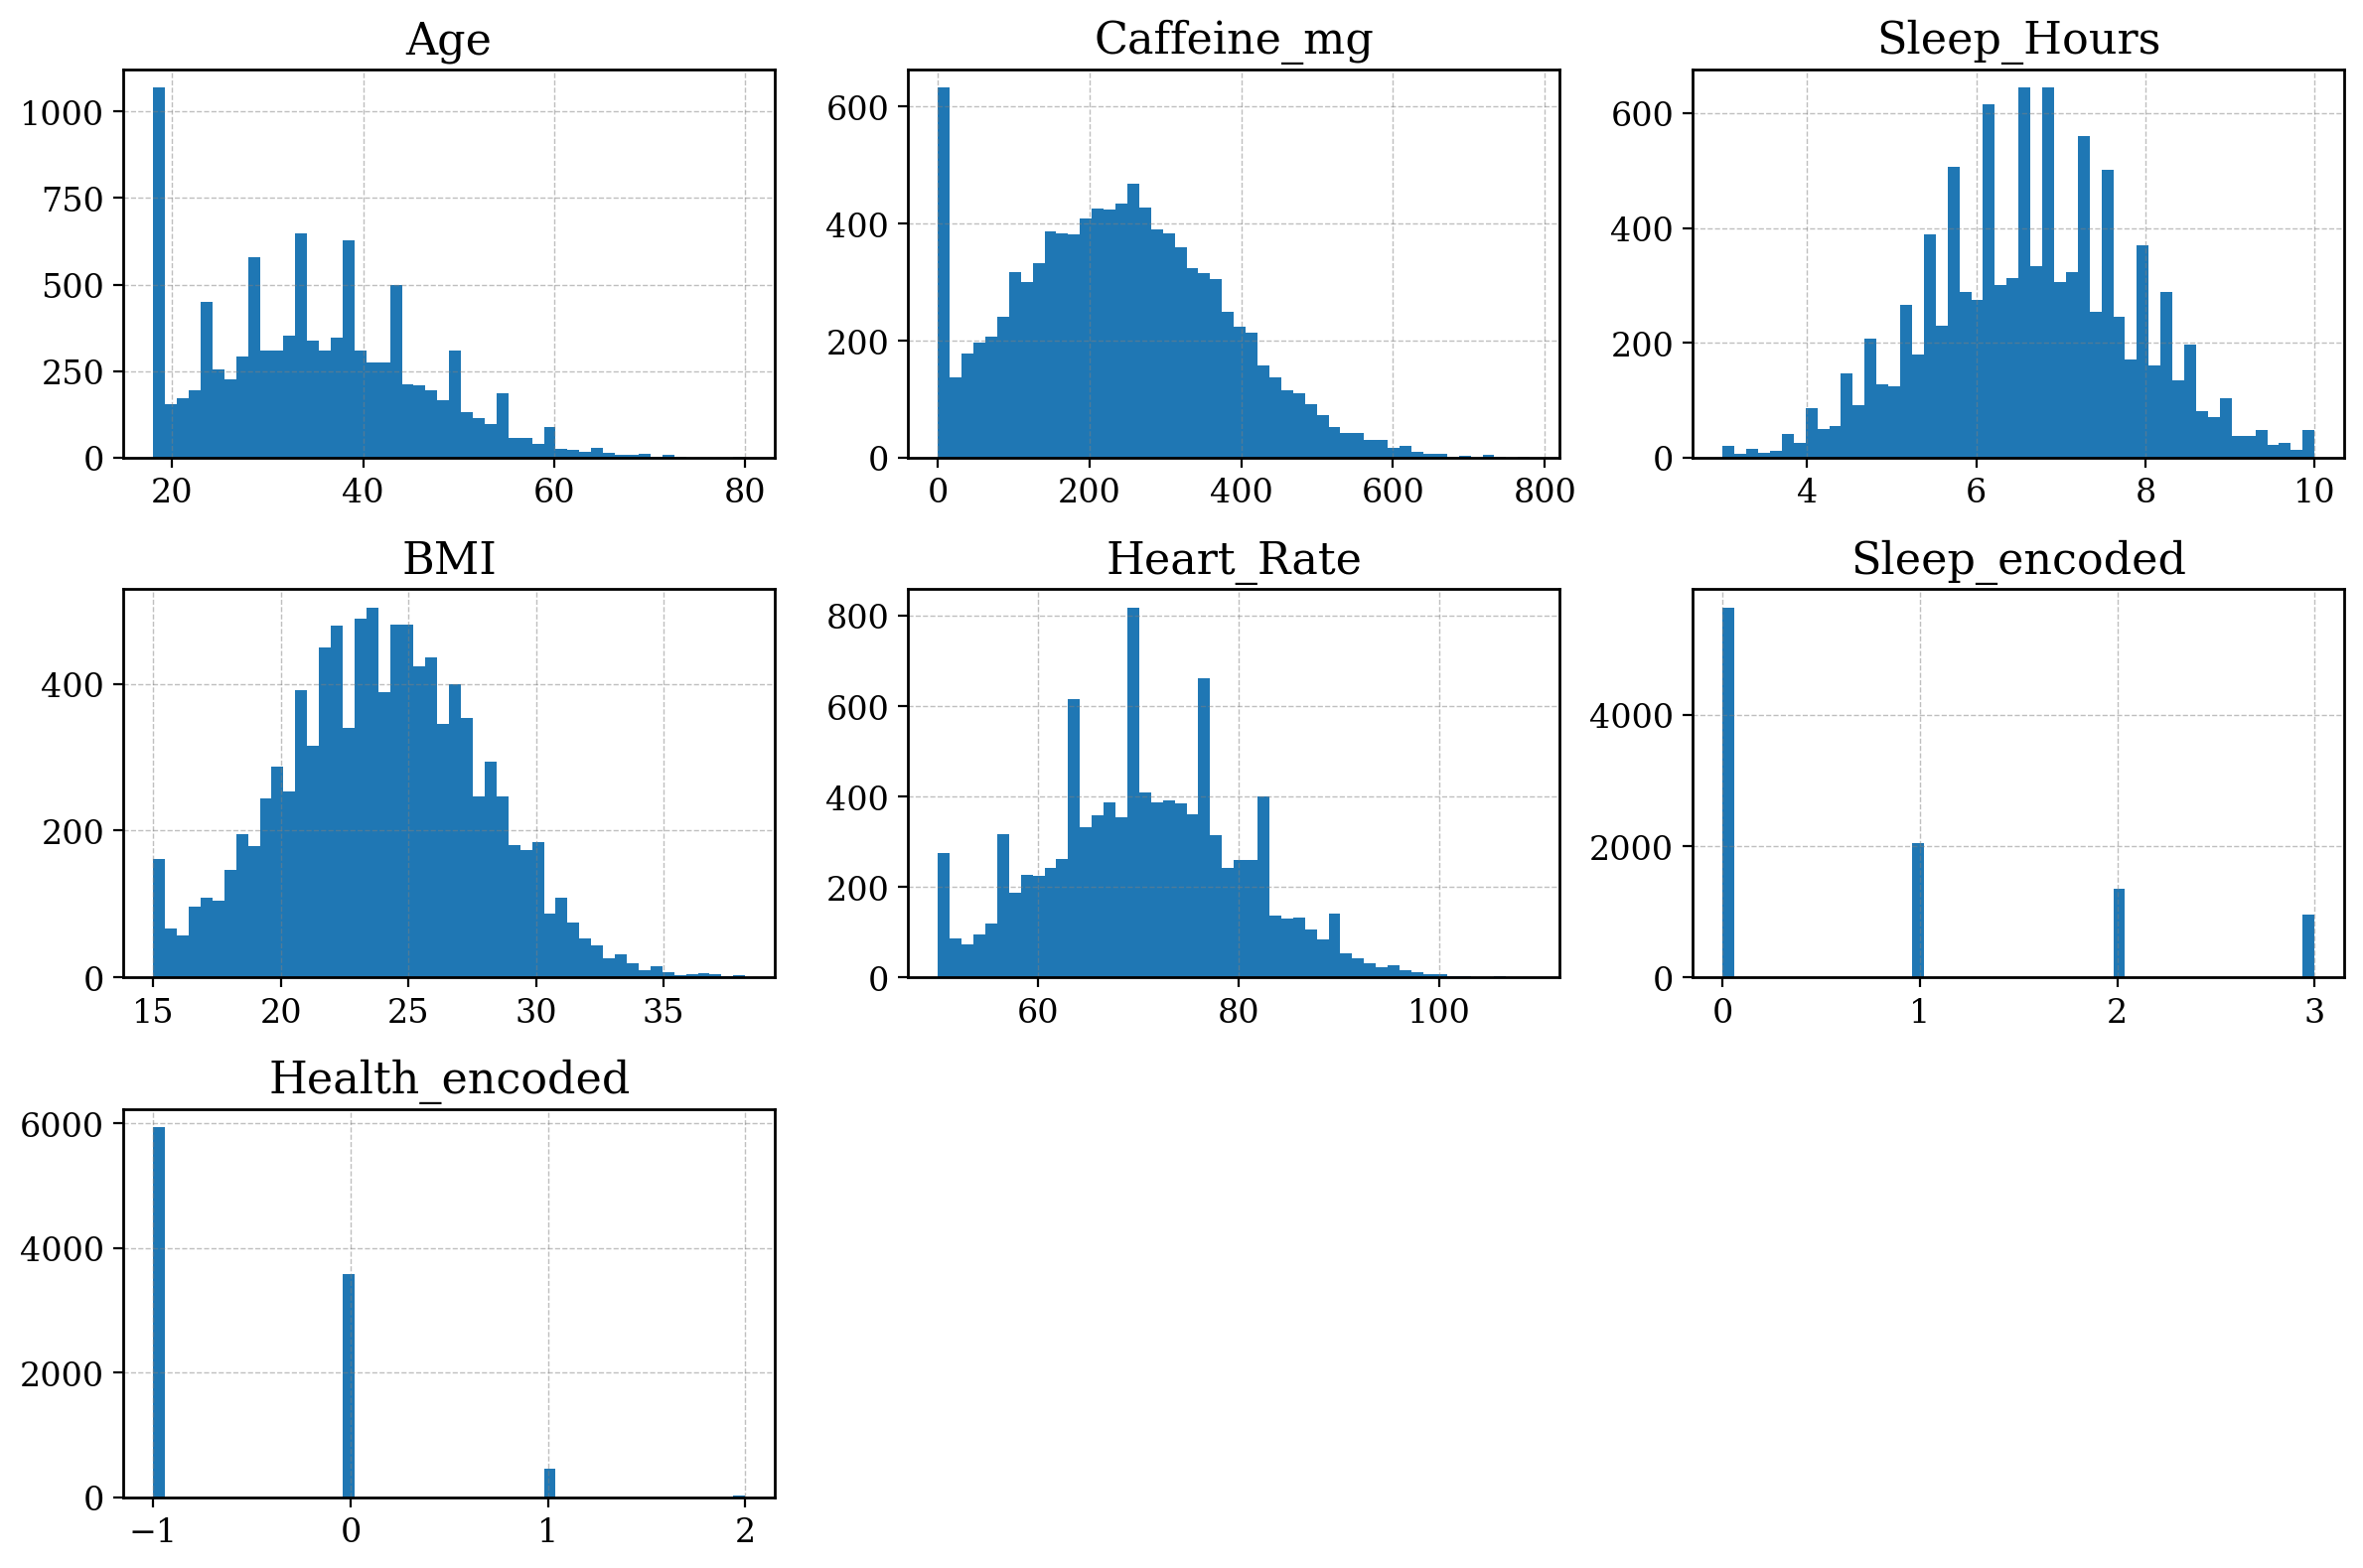

In [60]:
data.hist(bins=50, figsize=(12, 8))
plt.tight_layout()

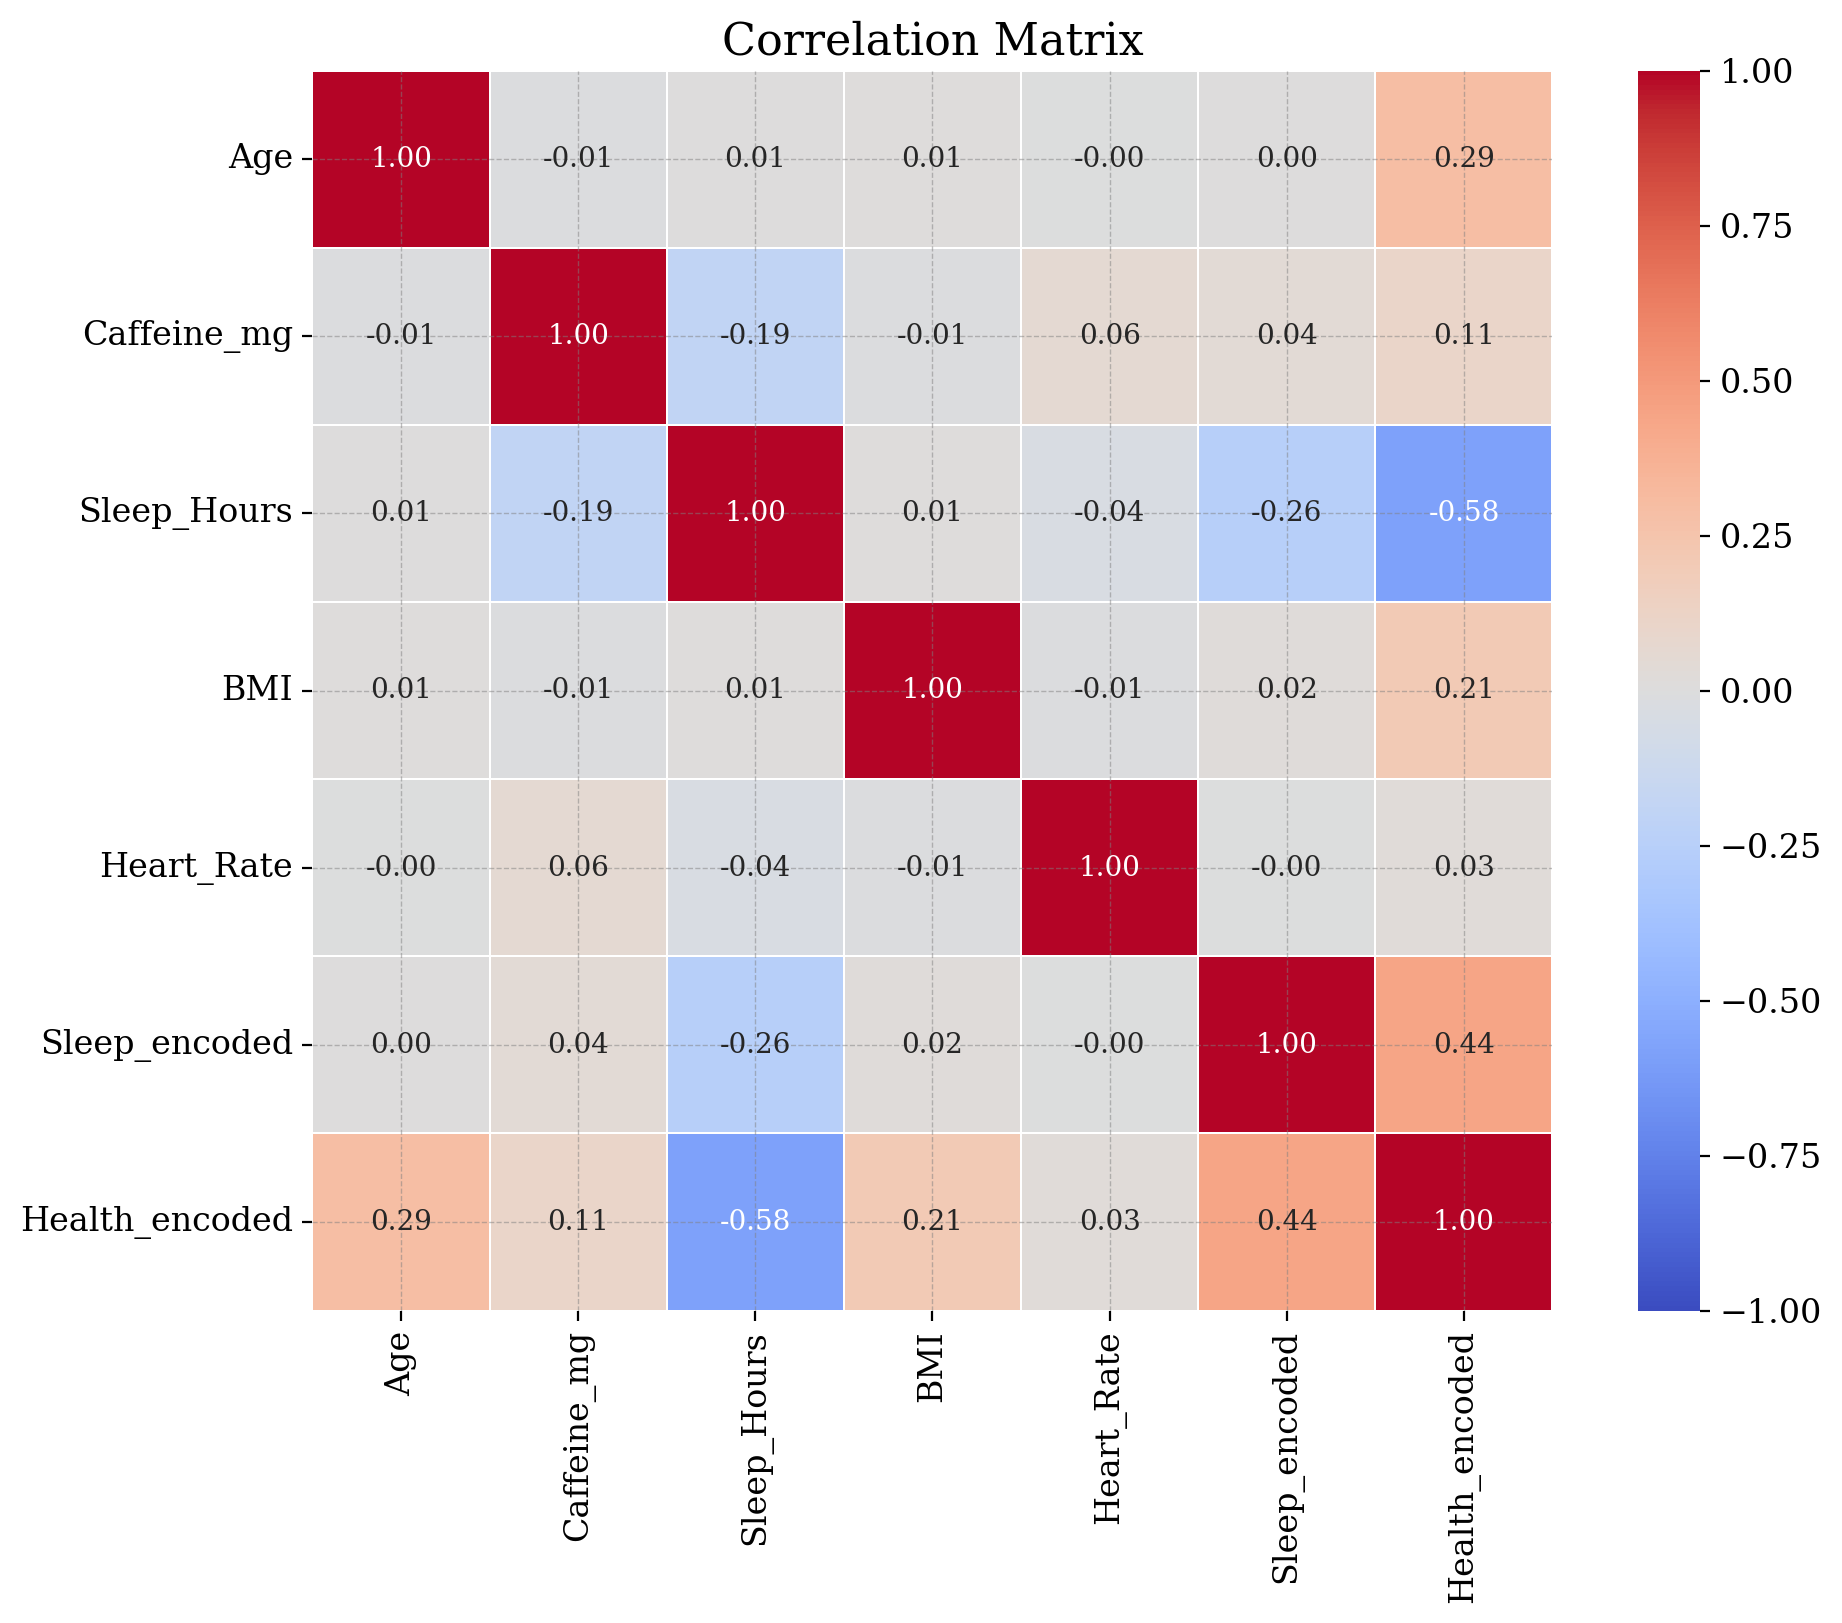

In [61]:
corr = data.corr(numeric_only=True)

# Show heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            annot=True, fmt=".2f",
            vmax=1.0, vmin=-1.0,
            linewidths=0.1,
            cmap="coolwarm",
            square=True, cbar=True)
plt.title("Correlation Matrix")
#plt.tight_layout()
plt.show()

Based on the correlation matrix, we can drop the features "Occupation", "Gender", "Country", "Alcohol", "Smoking" and "Physical Activity", since they are fully uncorrelated with all the other other features except themselve.

Furthermore, "Coffee" seems to be equivalent to "Caffeine intake", no surprise, so we can drop one of them as well.

Note: Between "Country" and "Smoking" seems to be a slight correlation, but nothing note worthy.

Main Target: "Health" (aka Classification problem)

In [62]:
from sklearn.preprocessing import LabelEncoder


train_df, val_df = train_test_split(data, test_size=0.3, random_state=42)


# Apply label encoding to categorical column
label_encoder = LabelEncoder()
# train_df["Gender"] = label_encoder.fit_transform(train_df["Gender"])
# val_df["Gender"]   = label_encoder.transform(val_df["Gender"])

# train_df["Country"] = label_encoder.fit_transform(train_df["Country"])
# val_df["Country"]   = label_encoder.transform(val_df["Country"])

train_df["Sleep_Quality"] = label_encoder.fit_transform(train_df["Sleep_Quality"])
val_df["Sleep_Quality"]   = label_encoder.transform(val_df["Sleep_Quality"])

train_df["Stress_Level"] = label_encoder.fit_transform(train_df["Stress_Level"])
val_df["Stress_Level"]   = label_encoder.transform(val_df["Stress_Level"])

train_df["Health_Issues"] = label_encoder.fit_transform(train_df["Health_Issues"])
val_df["Health_Issues"]   = label_encoder.transform(val_df["Health_Issues"])

# train_df["Occupation"] = label_encoder.fit_transform(train_df["Occupation"])
# val_df["Occupation"]   = label_encoder.transform(val_df["Occupation"])

# Use the entire features for X_train and X_val

useless = ["Health_Issues"]

X_train = train_df.drop(columns=useless).values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df.drop(columns=useless).values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

Best Parameters from RandomizedSearchCV: {'full_dt_regressor__max_depth': 8, 'full_dt_regressor__min_samples_leaf': 4, 'full_dt_regressor__min_samples_split': 6}
Decision Tree regression metrics:
MSE: 0.0000
MAE: 0.0000
SSR: 0.0000
R2-score: 1.0000

Cross-Validated R2-Scores: [1.         1.         0.99912123 1.         1.         1.
 1.         1.         1.         1.        ]
Average Cross-Validated R2: 0.9999


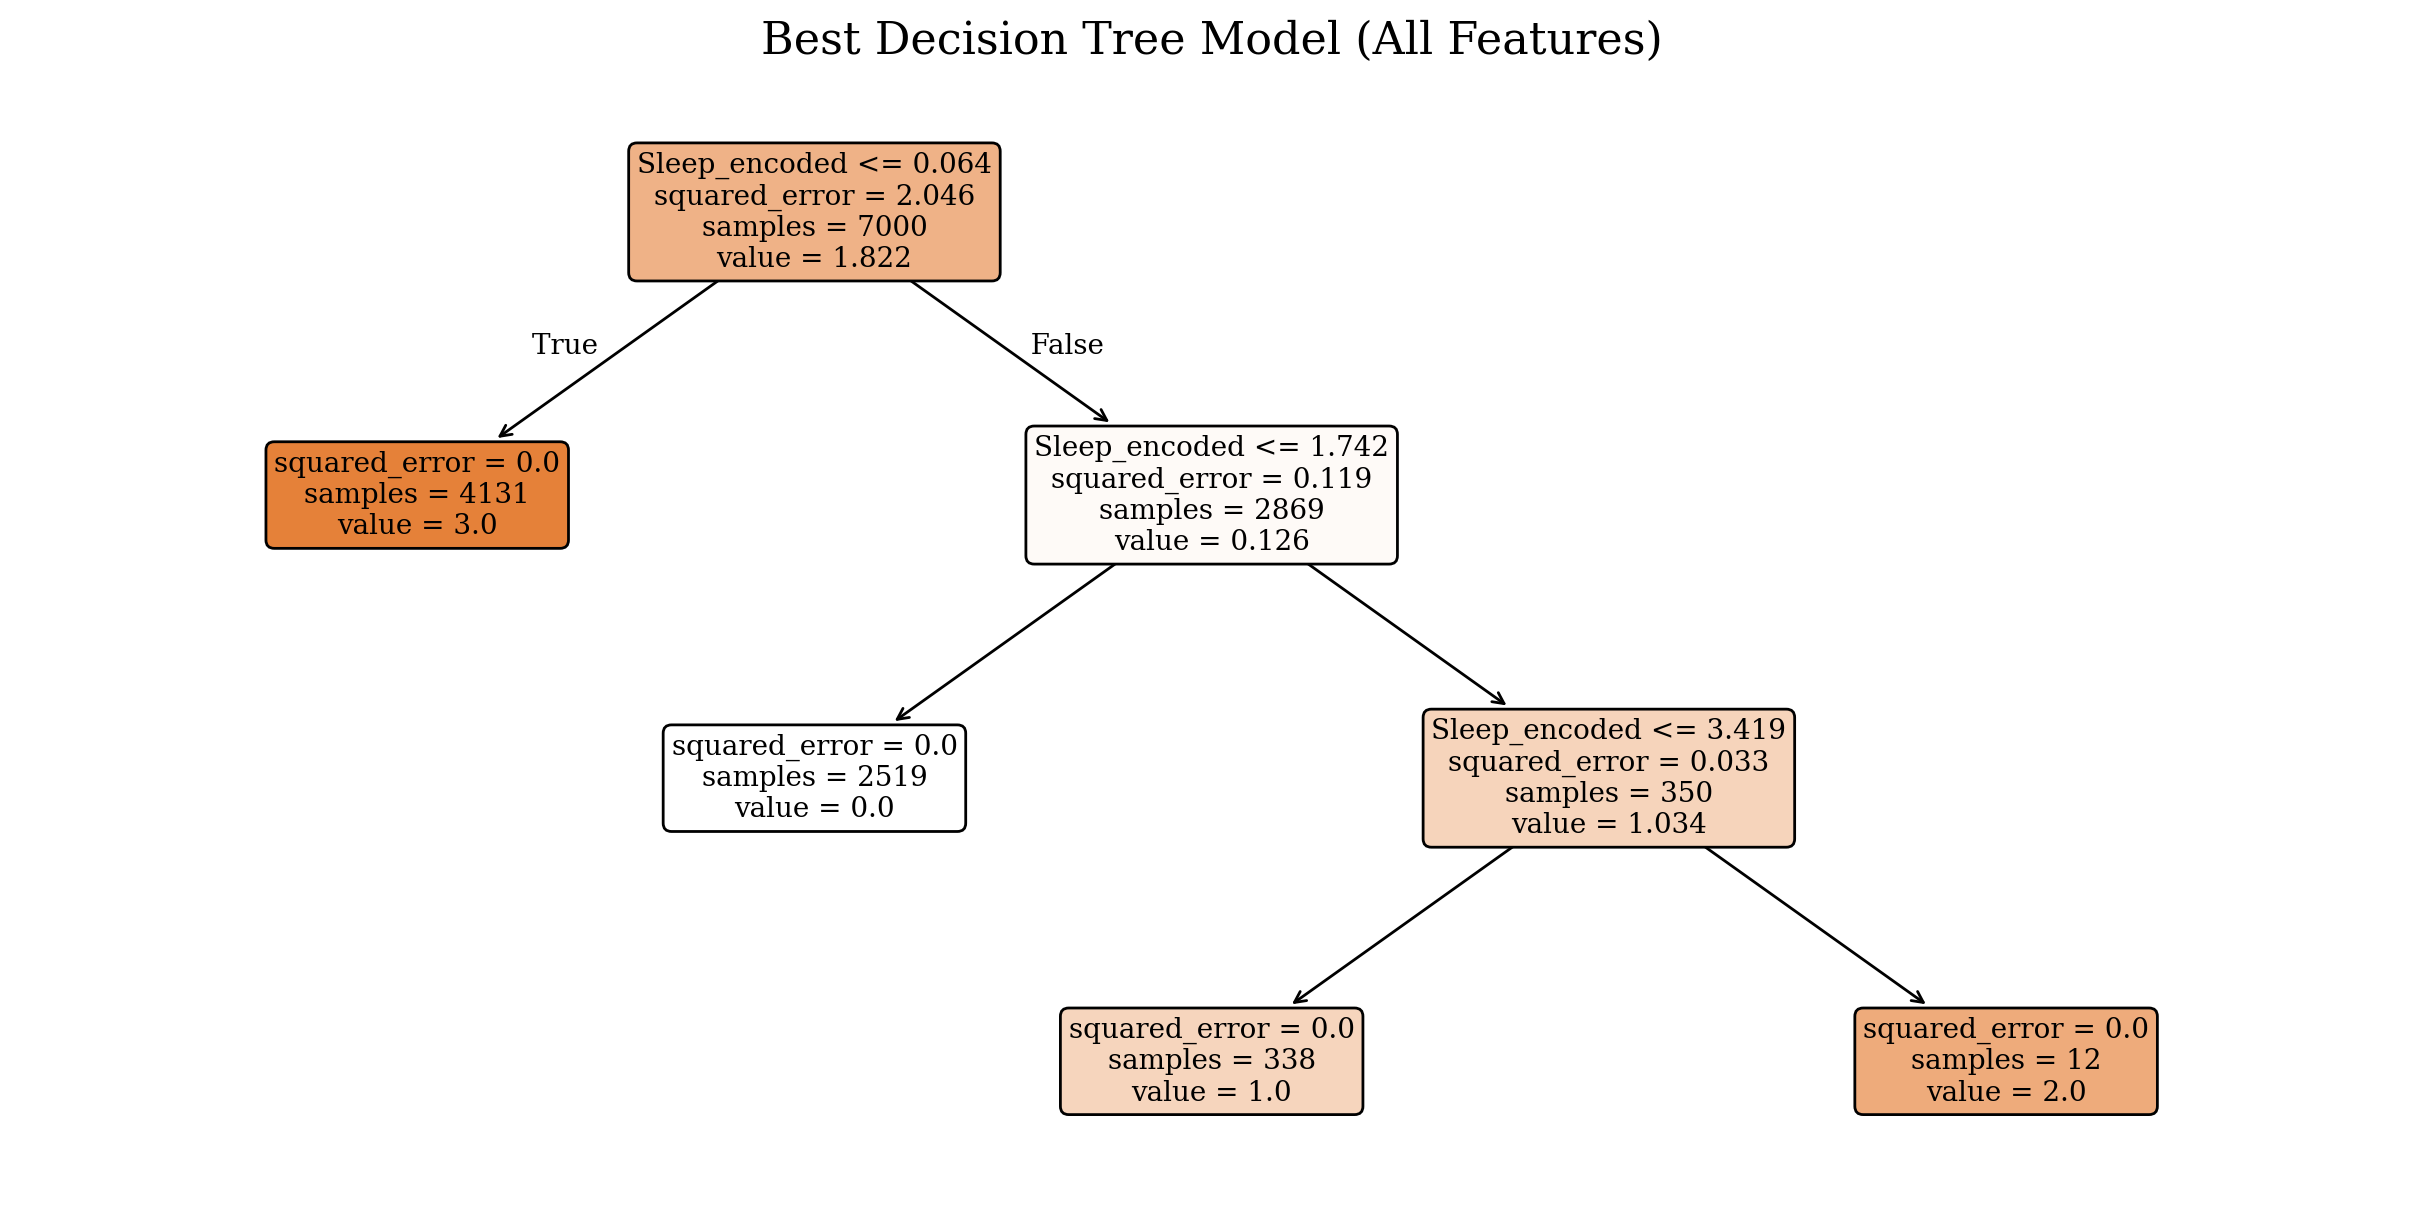

In [63]:
# Build pipeline
new_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('full_dt_regressor', DecisionTreeRegressor(random_state=42))  # Train Decision Tree Regressor
])

# Hyperparameter search space
param_distributions = {
    'full_dt_regressor__max_depth'        : randint(2, 10),
    'full_dt_regressor__min_samples_split': randint(2, 10),
    'full_dt_regressor__min_samples_leaf' : randint(1, 10)
}

# Randomized search with cross-validation
search = RandomizedSearchCV(
    estimator=new_pipeline,   # Use the new pipeline
    param_distributions=param_distributions, # Hyperparameter search space
    n_iter       = 30,    # Number of iterations for random search
    cv           = 10,     # Cross-validation folds
    scoring      = 'r2',  # Scoring metric for evaluation
    n_jobs       = -1,    # Use all available CPU cores
    random_state = 42,    # Random state for reproducibility
)

# Fit search
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict on validation set
y_pred = best_model.predict(X_val)

# Evaluation metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
ssr = np.sum((y_val - y_pred) ** 2)
r2 = r2_score(y_val, y_pred)

print("Best Parameters from RandomizedSearchCV:", search.best_params_)
print("Decision Tree regression metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SSR: {ssr:.4f}")
print(f"R2-score: {r2:.4f}")

# Cross-validation with best model
cv_scores = cross_val_score(best_model, X_val, y_val, cv=10, scoring='r2')
print(f"\nCross-Validated R2-Scores: {cv_scores}")
print(f"Average Cross-Validated R2: {cv_scores.mean():.4f}")

# Visualize the Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(best_model.named_steps['full_dt_regressor'], feature_names=train_df.columns,
          filled=True,
          rounded=True,
          max_depth=10,  # You can remove or increase this if the tree is shallow
          fontsize=10)
plt.title("Best Decision Tree Model (All Features)")
plt.show()

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_44335/779080082.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(train_df.drop(columns=useless).columns, rotation=65)


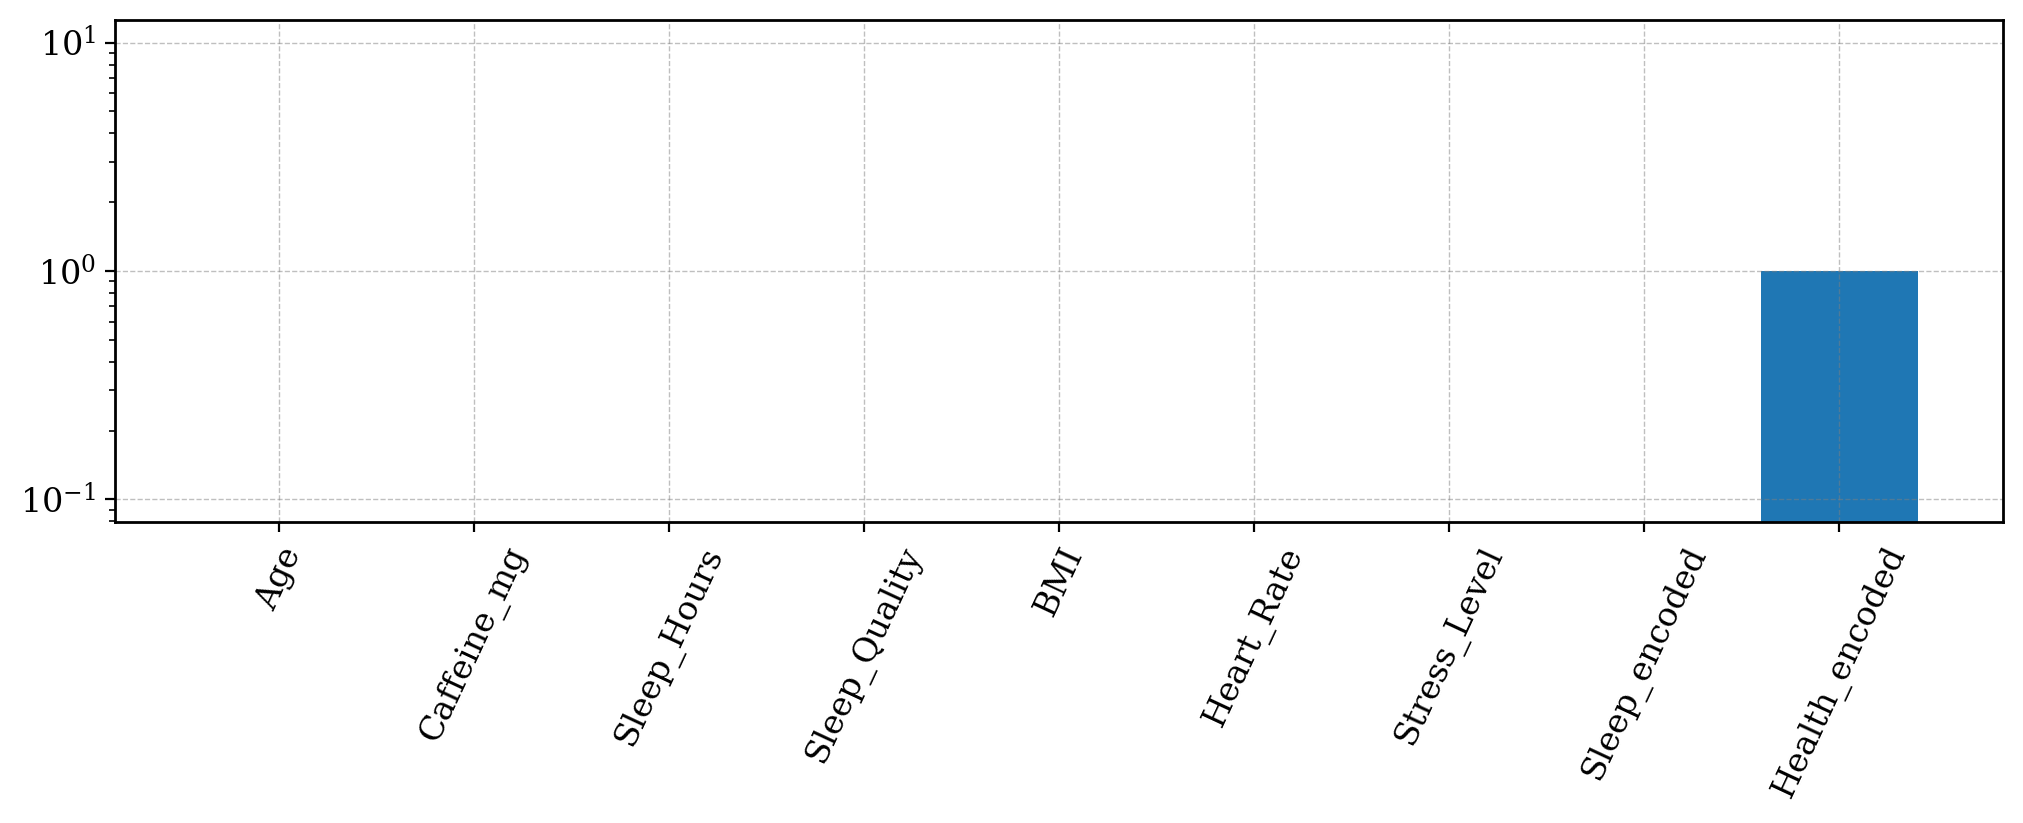

In [71]:
useless = ["Health_Issues"]
X_feat= train_df.drop(columns=useless).values  # Exclude "Gain" from training features
y_feat = train_df["Health_Issues"].values  # Target variable

new_pipeline.fit(X_feat, y_feat)

hmm = new_pipeline.named_steps['full_dt_regressor'].feature_importances_

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(train_df.drop(columns=useless).columns,hmm,log=True)
ax.set_xticklabels(train_df.drop(columns=useless).columns, rotation=65)
plt.show()